Análise Exploratória e Classificação de Vinhos com Machine Learning
---

Este notebook compreende uma avançada análise exploratória de dados para a construção de um classificador de documentos baseado em Aprendizado de Máquina (Machine Learning, ML).

Em geral, o pipeline passa pelas seguintes etapas:

    1. Coleta e preparação dos dados
    2. Preparação do ambiente de experimentação
    3. Análise exploratória dos documentos
    4. Modelagem
    5. Avaliação
    6. Deploy

# Descrição do Problema

O presente problema se refere aos dados de vinhos portugueses "Vinho Verde", que possuem variantes de vinho branco e tinto.
Devido a questões de privacidade, apenas variáveis físico-químicas (input) e sensoriais (output) estão disponíveis (por
exemplo, não há dados sobre tipo de uva, marca do vinho, preço de venda, etc).

**Informação sobre os atributos:**

> Variáveis *input* (baseado em testes físico-químicos):
    1. Tipo
    2. Acidez fixa
    3. Volatilidade da acidez
    4. Ácido cítrico
    5. Açúcar residual
    6. Cloretos
    7. Dióxido de enxofre livre
    8. Dióxido de enxofre total
    9. Densidade
    10. pH
    11. Sulfatos
    12. Álcool

> Variável *output* (baseado em dado sensorial):
    13. Qualidade (score entre 0 and 10)

**OBJETIVO:** Criar um modelo para estimar a qualidade do vinho. 



# Preparando Ambiente

In [1]:
import pandas as pd
import pandas_profiling

import os 
import numpy as np

SEED = 33
np.random.seed(SEED)


import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pylab as pylab
params = {
    'legend.fontsize': 'x-large',
    'figure.figsize': (15, 8),
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'axes.titlepad': 20,
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large'
}
pylab.rcParams.update(params)

import seaborn as sns
sns.set(style="white")

import plotly.offline as py
import plotly.express as px
py.init_notebook_mode(connected=True);

from tqdm import tqdm, tqdm_notebook
from collections import Counter

import warnings
warnings.filterwarnings(action='ignore')

from pprint import pprint
from time import time
import logging
from IPython.display import display

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics

from imblearn.over_sampling import RandomOverSampler

# Parâmetros de análise / modelagem
SEED = 33
np.random.seed(SEED)

TEST_SIZE = 0.1

CLASS_COLUMN = "quality"

In [2]:
# Base de dados original
df_raw = pd.read_csv('data/winequality.csv', sep=";")

# Análise exploratória dos Dados

## Estatísticas Básicas

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
type                    6497 non-null object
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null object
quality                 6497 non-null int64
dtypes: float64(10), int64(1), object(2)
memory usage: 660.0+ KB


In [4]:
df_raw.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,1.710882,3.218501,0.531268,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,7.636088,0.160787,0.148806,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,103.898000,4.010000,2.000000,9.000000


In [5]:
df_raw.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**CONCLUSÕES PARCIAIS**: Após uma primeira análise superficial, é possível observar duas questões:

    1. O atributo **type** está estruturada com valores categóricos (e.g. 'White' - *String*);
    2. Já o atributo **alcohol** apesar de ser descrito como categórico (tipo *object*) possui valores aparentemente numéricos; este fenômeno fica evidente ao observarmos que tal atributo não está presente no dataframe oriundo do método *describe()*, o qual apresenta um resumo estatístico de atributos com valores numéricos do dataset.
    
Estas observações citadas demonstram que há problema de integridade nos dados, que nos levará a lançar mão de etapas de pré-processamento para eliminar tais inconsistências.

## Estatísticas Avançadas

Grande parte do sucesso de aplicações de Ciência de Dados está no pleno entendimento das características dos dados. Neste sentido, além de estatísticas básicas, é importante analisar individualmente as propriedades de cada atributo, para avaliar seus detalhes, distribuições e suas correlações existentes.

Obviamente, realizar uma análise robusta requer domínio de diferentes ferramentas, conceitos e técnicas avançadas, o que obviamente não é uma tarefa trivial. Todavia, é importante ter conhecimento de 'caminhos' que agilizem o processo de Descoberta de Conhecimento. Neste sentido, para uma análise completa do conjunto de dados, irei utilizar o pacote `pandas_profiling` que permite a cientistas de dados terem um panorama abrangente dos dados em que estão trabalhando.

In [6]:
df_raw.profile_report(style={'full_width':True})

## Pré-processamento

#### Atributo `Alcohol`

In [7]:
# Avaliando registros disponíveis para o atributo - Imaginando que valores inconsistentes são 'casos isolados'
alcohol_counts = df_raw["alcohol"].value_counts()
alcohol_counts[alcohol_counts == 1]

11.65                  1
963.333.333.333.333    1
12.05                  1
131.333.333.333.333    1
8                      1
114.666.666.666.667    1
923.333.333.333.333    1
13.05                  1
10.75                  1
9.05                   1
113.666.666.666.667    1
123.333.333.333.333    1
120.666.666.666.667    1
105.666.666.666.667    1
10.65                  1
14.9                   1
13.55                  1
11.55                  1
114.333.333.333.333    1
12.25                  1
956.666.666.666.667    1
11.35                  1
9.25                   1
135.666.666.666.667    1
14.05                  1
9.75                   1
8.0                    1
105.333.333.333.333    1
10.98                  1
9.95                   1
112.666.666.666.667    1
14.2                   1
117.333.333.333.333    1
11.85                  1
Name: alcohol, dtype: int64

In [8]:
def convert_alcohol(x): 
    """
    Função baseada em `https://github.com/feebarscevicius/vinho-verde/blob/master/utils.py`
    Converte os valores do preditor `alcohol` para float,
    cuidando dos casos com formatação inconsistente. Utilizar
    no método `apply` do pd.DataFrame
    
    Args:
        x: observação no DataFrame
    Returns:
        Valor de `x` convertido para `float`
    """    
    
    try:
        x = float(x)
        
    except ValueError:
        x = x[:2] + '.' + x[2]
        x = float(x)
        
        if x > 50:
            x /= 10

    return x

df_raw["alcohol"] = df_raw["alcohol"].apply(convert_alcohol)

#### Atributo `Type`

In [9]:
# Transformando N valores do atributo Type em N atributos binários, one N = 2, "Red" e "White")
df = df_raw.copy()
df = pd.concat([df, pd.get_dummies(df['type'], prefix='type')], axis=1)

In [10]:
df.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type_Red,type_White
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0,1
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0,1
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0,1
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1


#### Normalizando atributos (escala [0, 1])

In [11]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
df.loc[:, ~df.columns.isin(["type", "type_White", "type_Red", CLASS_COLUMN]) ] = \
    scaler.fit_transform(df.loc[:, ~df.columns.isin(["type", "type_White", "type_Red", CLASS_COLUMN]) ].values)


## Análise do atributo alvo: `quality`

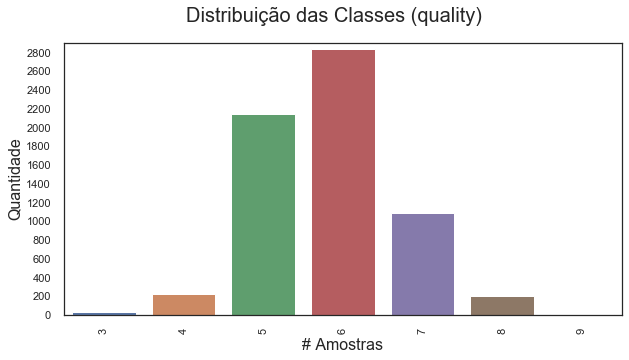

In [12]:
fig = plt.figure(figsize=(10, 5))

fig.suptitle("Distribuição das Classes ({})".format(CLASS_COLUMN), fontsize=20)
g0 = sns.countplot( x = CLASS_COLUMN, data = df)
plt.yticks(range(0, 2900, 200))
plt.ylim(0, 2900)
plt.xlabel('# Amostras', fontsize=16)
plt.ylabel("Quantidade", fontsize=16);
plt.xticks(rotation=90);

In [13]:
df["quality"].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

**CONCLUSÃO PARCIAL**: Aqui, vemos que o número de amostras por valor-classe é `consideravelmente desbalanceado`, característica que evidencia a necessidade de ajustar cuidadosamente o modelo de ML ou equilibrar artificialmente o conjunto de dados, por exemplo, subamostrando ou sobreamostrando cada classe.

Todavia, surge a seguinte hipótese:

> "Será que a amostragem, referente a variável `quality`, segue a mesma distribuição para cada tipo (`red`/ `white`) de vinho?"
 
Iremos validar esta hipótese, que pode ter um grande impacto no momento de modelagem.

In [14]:
# Dividindo o conjunto de dados
df_white = df.loc[ df["type_White"] == 1, :]
df_white = df_white.drop(["type_White", "type_Red"], axis=1)

df_red = df.loc[ df["type_Red"] == 1, :]
df_red = df_red.drop(["type_White", "type_Red"], axis=1)

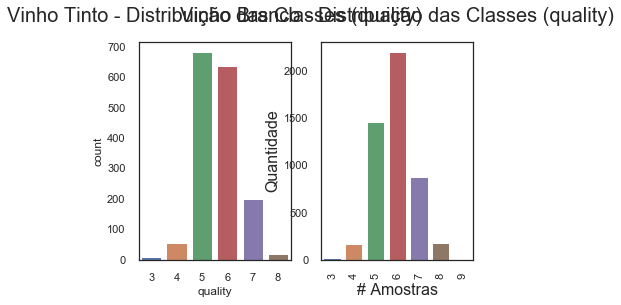

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title("Vinho Tinto - Distribuição das Classes ({})".format(CLASS_COLUMN), fontsize=20)
g0 = sns.countplot( x = CLASS_COLUMN, data = df_red, ax=ax1)
# plt.yticks(range(0, 2900, 200))
# plt.ylim(0, 2900)
plt.xlabel('# Amostras', fontsize=16)
plt.ylabel("Quantidade", fontsize=16);
plt.xticks(rotation=90);

ax2.set_title("Vinho Branco - Distribuição das Classes ({})".format(CLASS_COLUMN), fontsize=20)
g0 = sns.countplot( x = CLASS_COLUMN, data = df_white, ax=ax2)
# plt.yticks(range(0, 2900, 200))
# plt.ylim(0, 2900)
plt.xlabel('# Amostras', fontsize=16)
plt.ylabel("Quantidade", fontsize=16);
plt.xticks(rotation=90);

**Interessante!!!**

Podemos observar que o fenômeno de desabalanceamento é intrínseco a ambos tipos de vinhos, *mas a distribuição de qualidades muda de acordo com o tipo de vinho*.

<u>Por exemplo:</u> 
    * Não há vinhos de `quality=9` para vinho tinto;
    * Há muito mais vinhos com `qualidade` 6 do que 5 em vinhos branco, ao contrário de vinho tinto.
    
Logo, presume-se que os fatores que os fatores que impactam a qualidade do vinho varia de acordo com cada tipo. Isto poderia ser <u>validado em campo com o cliente ou especialistas no domínio do problema</u>.

Neste sentido, temos 2 caminhos a seguir para a construção de um classificador de qualidade de Vinhos baseado em Machine Learning:

>   1. Contruir um **`classificador hierárquico`**, que é constituído de camadas (ou níveis) que possuem modelos de ML treinados em conjuntos de dados segmentados. No contexto deste projeto, iremos uma estrutura de classificador que:

>       a. O primeiro nível de classificador irá checar se o vinho é Branco ou Tinto com base em suas características;
>       b. Em segundo nível, a amostra irá ser submetida a um classificador que irá definir sua qualidade.

>   2. Treinar um **`classificador único`**, com todos os dados independente do tipo de vinho (tinto ou branco);

Vale ressaltar que a primeira estratégia (abordagem hierárquica), conforme [Faceli *et. al*, 2011](https://www.amazon.com.br/Intelig%C3%AAncia-Artificial-Abordagem-Aprendizado-M%C3%A1quina/dp/8521618808), visa quebrar um problema complexo em vários problemas mais 'simples'.

# Modelagem

In [16]:
def best_evaluated_model(X, y, cv = 5):
    
    # Instanciando modelos (lista de modelos) baseline
    models = [
        DummyClassifier(
            random_state=SEED
        ),
        RandomForestClassifier(
            class_weight = 'balanced', 
            random_state=SEED
        ),
        MultinomialNB(),
        SGDClassifier(
            class_weight = 'balanced', 
            random_state=SEED
        ),
        LogisticRegression(
            class_weight = 'balanced', 
            random_state=SEED
        )
    ]

    # DataFrame que irá guardar os resultados de 5 tentativas dos 3 modelos
    cv_df = pd.DataFrame(index=range(cv * len(models)))
    entries = []

    # Para cada modelo
    print('Avaliando modelos, aguarde...')
    for model in tqdm_notebook(models):
        model_name = model.__class__.__name__

        # Avaliar o resultado (considerando a matriz TF-IDF e rótulos)
        scores = cross_val_score(
            model, 
            X, y, 
            cv = cv, 
            scoring='f1_micro',
            n_jobs = 8, 
            verbose = 0
        )

        # Adicionando as acurácias resultantes do CV para o modelo em questão
        for fold_idx, score in enumerate(scores):
            entries.append((model_name, fold_idx, score))

    # Estruturando resultados como DataFrame
    cv_df = pd.DataFrame(entries, columns=['Modelo', 'Fold', 'Score'])

    # Visualizando os resultados
    fig = plt.figure(figsize=(15, 8))
    sns.boxplot(x='Modelo', y='Score', data=cv_df)
    sns.stripplot(
        x='Modelo', y='Score', data=cv_df, 
        size=8, jitter=True, edgecolor="gray", linewidth=2);

    # Visão Analítica
    performance = cv_df.groupby('Modelo').agg({"Score": ['mean', 'std']})
    print('Resultado da avaliação de modelos com validação cruzada ({} folds):'.format(cv))
    display(performance)

    # Definindo o modelo baseline, com base na performance (visao analitica anterior)
    idx_baseline = np.argmax(performance['Score']['mean'].values)
    # Capturando o modelo em si
    for i, model in enumerate(models):
        if model.__class__.__name__ == performance.index[idx_baseline]:
            idx_baseline = i
            break

    # Instanciando o modelo baseline      
    baseline_model = models[idx_baseline]
    #print('Modelo baseline escolhido:\n', baseline_model)

    return baseline_model

## Hipótese 1) Classificador hierárquico

### Classificador de Primeiro nível: Vinho tinto ou branco?

Avaliando modelos, aguarde...



Resultado da avaliação de modelos com validação cruzada (10 folds):


Score          
                            mean       std
Modelo                                    
DummyClassifier         0.612128  0.000404
LogisticRegression      0.983685  0.003920
MultinomialNB           0.753887  0.000287
RandomForestClassifier  0.994306  0.003247
SGDClassifier           0.988149  0.006325

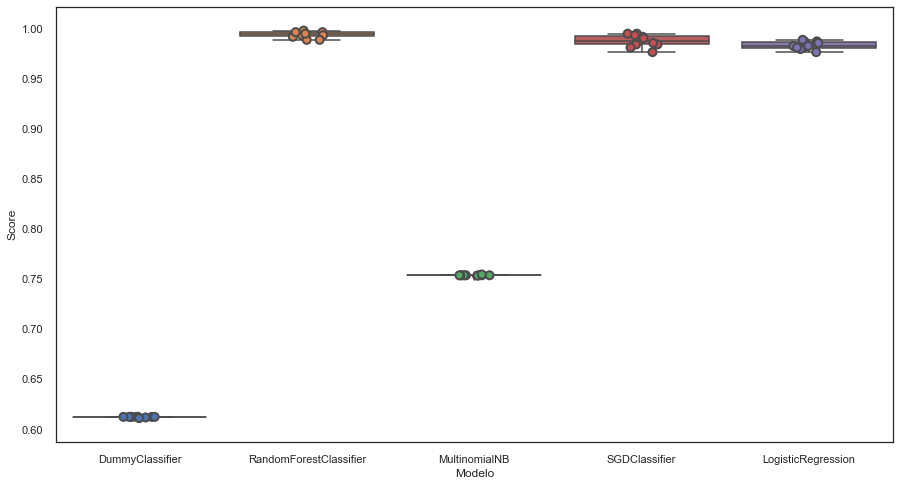

In [17]:
# X_level0 = entrada do ensemble de classificadores
X_level0 = df.loc[:, ~df.columns.isin(["type", "type_White", "type_Red", CLASS_COLUMN]) ]
y_level0 = df["type"].values

modelo_level0 = best_evaluated_model(X_level0, y_level0, cv = 10)

**CONCLUSÕES PARCIAIS**: conforme esperado, o melhor modelo classificador (uma Floresta de Árvores de Decisão, ou `RandomForestClassifier`) de tipo de vinho conseguiu excelente performance, obtendo um `F1-score` *(micro, dada a característica desbalanceada)* de ~99% <u>com validação cruzada de 10 folds</u>, o que nos dá tranquilidade de continuarmos com a construção de nosso ensemble. 

### Classificador de Segundo nível: qualidade do vinho (ajuste por tipo)

#### Treinando para Vinho Tinto

Avaliando modelos, aguarde...



Resultado da avaliação de modelos com validação cruzada (10 folds):


Score          
                            mean       std
Modelo                                    
DummyClassifier         0.349195  0.034886
LogisticRegression      0.524871  0.055532
MultinomialNB           0.518461  0.060600
RandomForestClassifier  0.554866  0.033786
SGDClassifier           0.450339  0.144621

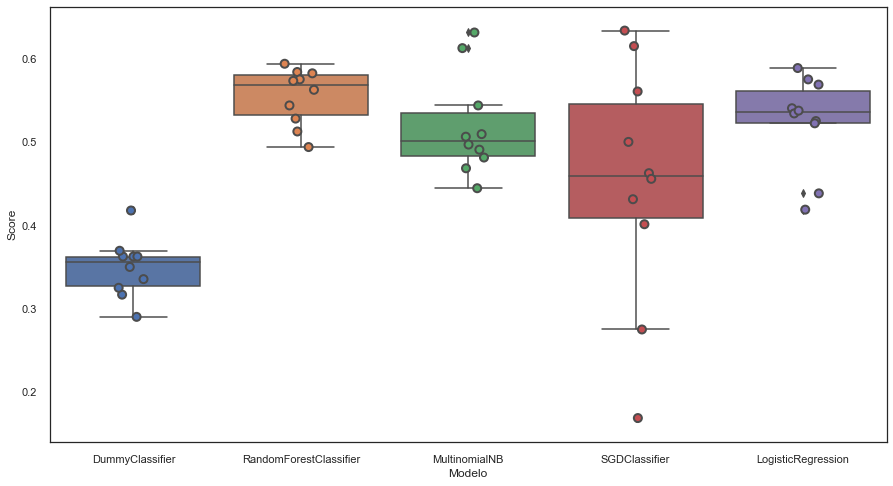

In [18]:
# X_level0 = entrada do ensemble de classificadores
X_level1_red = df.loc[ df["type"] == "Red", ~df.columns.isin(["type", "type_White", "type_Red", CLASS_COLUMN]) ]
y_level1_red = df.loc[ df["type"] == "Red", "quality"].values

model_level1_red = best_evaluated_model(X_level1_red, y_level1_red, cv = 10)

**CONCLUSÕES PARCIAIS**: o mellhor modelo avaliado ainda possui performance não muito razoável. Por isso, vamos avaliar o possível motivo deste resultado.

In [19]:
# Split dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_level1_red, y_level1_red, 
    test_size = TEST_SIZE, 
    random_state = SEED
)

model_level1_red.fit(X_train, y_train)

y_pred = model_level1_red.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       1.00      0.17      0.29         6
           5       0.67      0.76      0.71        67
           6       0.56      0.61      0.59        59
           7       0.74      0.56      0.64        25
           8       0.00      0.00      0.00         2

    accuracy                           0.64       160
   macro avg       0.50      0.35      0.37       160
weighted avg       0.64      0.64      0.62       160



Podemos observar que o desbalanceamento possui grande impacto no ajuste do modelo. Sendo assim, vamos aplicar uma técnica de Oversampling nos dados, a fim de balancear sinteticamente os mesmos e obter um dataset mais factível para o modelo.

Avaliando modelos, aguarde...



Resultado da avaliação de modelos com validação cruzada (10 folds):


Score          
                            mean       std
Modelo                                    
DummyClassifier         0.167196  0.013475
LogisticRegression      0.499524  0.028197
MultinomialNB           0.436324  0.029535
RandomForestClassifier  0.862724  0.029104
SGDClassifier           0.472471  0.033645

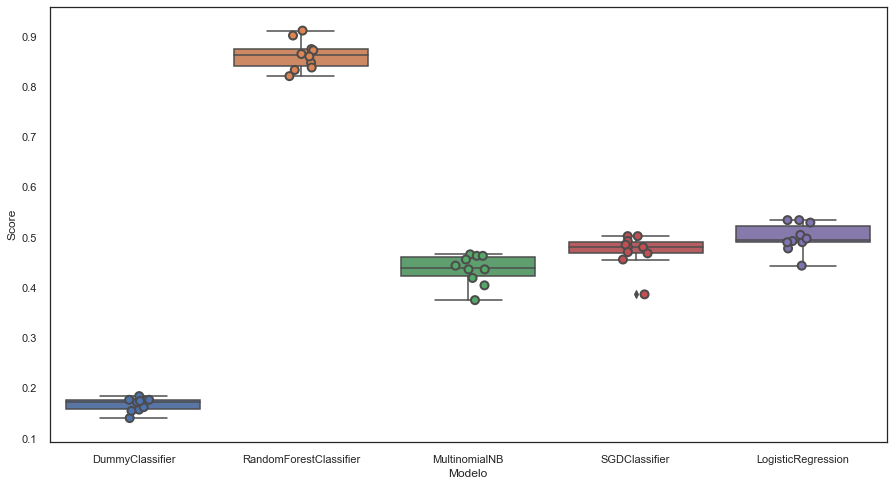

In [20]:
X_level1_red_resampled, y_level1_red_resampled = \
    RandomOverSampler(random_state=SEED).fit_resample(X_level1_red, y_level1_red)

model_level1_red = best_evaluated_model(X_level1_red_resampled, y_level1_red_resampled, cv = 10)

In [21]:
# Split dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_level1_red_resampled, y_level1_red_resampled, 
    test_size = TEST_SIZE, 
    random_state = SEED
)

model_level1_red.fit(X_train, y_train)

y_pred = model_level1_red.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.99      1.00      0.99        69
           4       0.96      1.00      0.98        66
           5       0.84      0.78      0.81        79
           6       0.77      0.69      0.73        54
           7       0.90      1.00      0.95        66
           8       1.00      1.00      1.00        75

    accuracy                           0.92       409
   macro avg       0.91      0.91      0.91       409
weighted avg       0.91      0.92      0.91       409



**Ótimo!!!**

Como podemos observar acima, o processo de `Oversampling` otimizou os resultados do classificador, nos fornecendo um modelo com desempenho `~86% de F1-score` na avaliação com validação cruzada e `~91% de F1-score` no conjunto de teste!

Além disso, através do `classification_report`, observa-se que todas as classes estão com desempenho bastante razoável, o que nos trás maior segurança a cerca do comportamento do modelo. 

Deste modo, podemos assumir o mesmo processo para treinar o classificador de qualidade de `vinho branco`.

#### Treinando para Vinho Branco

Avaliando modelos, aguarde...



Resultado da avaliação de modelos com validação cruzada (10 folds):


Score          
                            mean       std
Modelo                                    
DummyClassifier         0.149035  0.006501
LogisticRegression      0.457052  0.018869
MultinomialNB           0.358844  0.017012
RandomForestClassifier  0.898638  0.027242
SGDClassifier           0.385881  0.024400

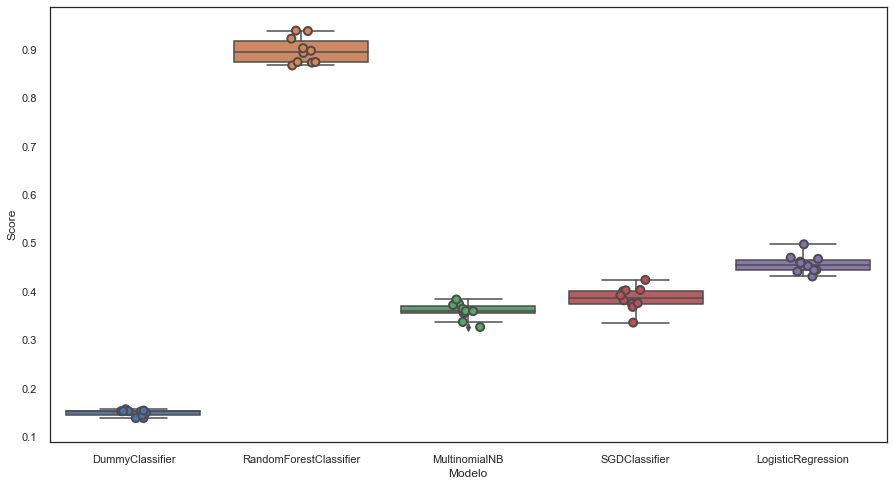

In [22]:
# X_level0 = entrada do ensemble de classificadores
X_level1_white = df.loc[ df["type"] == "White", ~df.columns.isin(["type", "type_White", "type_Red", CLASS_COLUMN]) ]
y_level1_white = df.loc[ df["type"] == "White", "quality"].values

X_level1_white_resampled, y_level1_white_resampled = \
    RandomOverSampler(random_state=SEED).fit_resample(X_level1_white, y_level1_white)

model_level1_white = best_evaluated_model(X_level1_white_resampled, y_level1_white_resampled, cv = 10)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X_level1_white_resampled, y_level1_white_resampled, 
    test_size = TEST_SIZE, 
    random_state = SEED
)

model_level1_white.fit(X_train, y_train)

y_pred = model_level1_white.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       1.00      1.00      1.00       210
           4       0.99      1.00      0.99       209
           5       0.81      0.86      0.83       216
           6       0.77      0.69      0.73       214
           7       0.90      0.92      0.91       223
           8       1.00      1.00      1.00       228
           9       1.00      1.00      1.00       239

    accuracy                           0.93      1539
   macro avg       0.92      0.92      0.92      1539
weighted avg       0.92      0.93      0.92      1539



Conforme esperado, encontramos um modelo com performance bastante interessante, novamente um classificador `RandomForest`, que obteve `~89,6% de F1-score` com validação cruzada e `~92%` desta mesma métrica no conjunto de teste, com performance individual bastante satisfatória.

Neste momento, temos um Ensemble bastante robusto o qual, divido em 3 modelos dispostos em duas camadas (ou níveis) potencialmente resolverão a classificação de maneira efetiva.

Por fim, como último teste, dado que o Oversampling mostrou uma grande melhoria no processo de construção de modelo, iremos avaliar se é possível construir um **modelo único** que classifique a qualidade do vinho independente do tipo (proposta antagônica ao Ensemble aqui discutido).

## Hipótese 2) Classificador único

Avaliando modelos, aguarde...



Resultado da avaliação de modelos com validação cruzada (10 folds):


Score          
                            mean       std
Modelo                                    
DummyClassifier         0.142158  0.007159
LogisticRegression      0.446660  0.021071
MultinomialNB           0.199732  0.008431
RandomForestClassifier  0.877752  0.014156
SGDClassifier           0.368928  0.052499

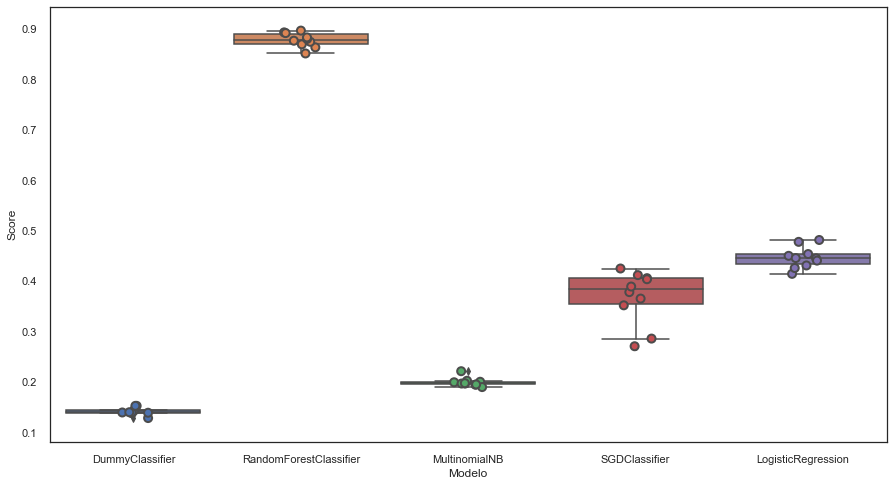

In [24]:
# X_level0 = entrada do ensemble de classificadores
X = df.loc[ :, ~df.columns.isin(["type", CLASS_COLUMN]) ]
y = df.loc[ :, "quality"].values

X_resampled, y_resampled = RandomOverSampler(random_state=SEED).fit_resample(X, y)

model = best_evaluated_model(X_resampled, y_resampled, cv = 10)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, 
    test_size = TEST_SIZE, 
    random_state = SEED
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       1.00      1.00      1.00       309
           4       0.99      1.00      0.99       263
           5       0.84      0.87      0.86       307
           6       0.84      0.72      0.78       290
           7       0.90      0.99      0.94       274
           8       1.00      1.00      1.00       272
           9       1.00      1.00      1.00       271

    accuracy                           0.94      1986
   macro avg       0.94      0.94      0.94      1986
weighted avg       0.94      0.94      0.94      1986



**Excelente!!!**

A adoção de Oversampling melhororu subtancialmente o modelo, ainda que único, para a classificação de qualidade de vinho: conseguimos um desempenho de `~88% de F1-score` na avaliação com validação cruzada (10 folds) e `~94% no conjunto de teste`!

Sendo assim, dada a menor complexidade de de construção e consequente menor custo computacional para seu processamento, iremos escolher a abordagem baseada em **`classificador único`** para este projeto.

# Otimização e Análise do Modelo

In [26]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title += ' (dados normalizados)'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    classes = unique_labels(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Original',
           xlabel='Classificado')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    plt.show();
    return ax

In [27]:
model

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=33, verbose=0, warm_start=False)

## Otimização de Hiperparâmetros do Modelo

A partir de um modelo base estabelecido, iremos tentar otimizar também seus hiperparâmetros. Para isto, iremos utiliza a Pesquisa em Grade Aleatorizada (RandomizedSearchCV), onde iremos delimitar um espaço de busca discreto a fim de encontrar a melhor combinação possível de hiperparâmetros do algoritmo (`RandomForestClassifier`) em questão.

In [28]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_grid = {
    'bootstrap': [True, False],
    'criterion': ["gini", "entropy"],
    'max_depth': [50, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10, 100, 1000, 3000]
}

# run randomized search
n_iter_search = 200
optmizer = RandomizedSearchCV(
    model, 
    param_distributions = param_grid,
    n_iter = n_iter_search, 
    cv = 5, 
    random_state=SEED,
    n_jobs = 10,    
    verbose = 8    
)

start = time()
print("Otimizando hiperparâmetros...")
optmizer.fit(X_resampled, y_resampled)

print("Otimização levou %.2f segundos para avaliar %d combinações de hiperparâmetros." % ((time() - start), len(optmizer.cv_results_['params'])))

print("Resultado final:")
report(optmizer.cv_results_)

Otimizando hiperparâmetros...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:  4.4min
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:  5.9min
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  8.6min
[Parallel(n_jobs=10)]: Done 201 tasks      | elapsed: 12.6min
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed: 17.4min
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed: 26.0min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 29.5min
[Parallel(n_jobs=10)]: Done 525 tasks      | elapsed: 39.2min
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed: 44.9min
[Parallel(n_jobs=10)]: Done 741 tasks      | elapsed: 54.8min
[Parallel(n_jobs=10)]: Done 862 tasks      | elapsed: 60.6min
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed: 75.3min finished


Otimização levou 4549.26 segundos para avaliar 200 combinações de hiperparâmetros.
Resultado final:
Model with rank: 1
Mean validation score: 0.884 (std: 0.014)
Parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.883 (std: 0.014)
Parameters: {'n_estimators': 3000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'entropy', 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.883 (std: 0.014)
Parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'criterion': 'gini', 'bootstrap': False}



In [29]:
print('Detalhes do modelo final otimizado via GridSearchCV...')
best_model = model.set_params(**optmizer.best_params_)
best_model

Detalhes do modelo final otimizado via GridSearchCV...


RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=33, verbose=0, warm_start=False)

## Análise do Modelo Otimizado

### Relevância de Atributos (Feature Importance)

In [30]:
features_names = df.columns[df.columns != CLASS_COLUMN]
features_names

Index(['type', 'fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'type_Red', 'type_White'],
      dtype='object')

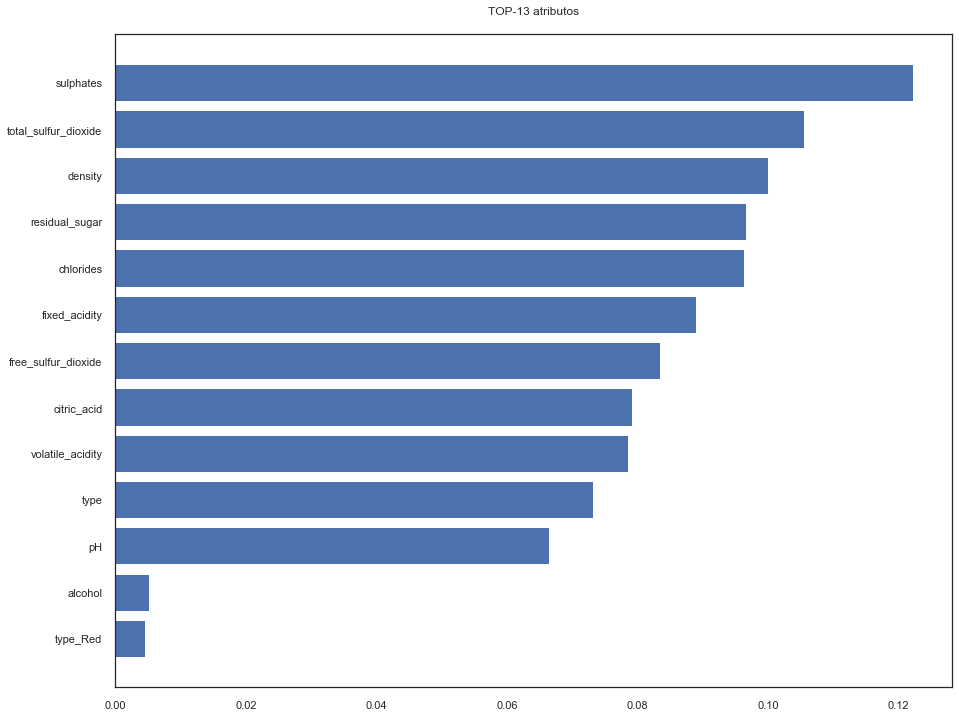

In [31]:
def var_imp_plot(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    fig = plt.figure(figsize=(15,12))
    plt.title('TOP-{} atributos'.format(len(coef)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

# Extrair Feat. Importances do modelo
importances = best_model.feature_importances_
var_imp_plot(importances, features_names)

### Resultados Obtidos (Validação Cruzada / Split de Treino e Teste)

In [32]:
# Avaliar o resultado (considerando a matriz TF-IDF e rótulos)
print("Avaliação final CV...")
scores = cross_val_score(
    best_model, 
    X_resampled, y_resampled, 
    cv = 10, 
    scoring='f1_micro',
    n_jobs = 8, 
    verbose = 0
)
print("Performance (F1-score) final: {}%".format( round(np.mean(scores)*100,1) ))

Avaliação final CV...
Performance (F1-score) final: 89.6%


Relatório de classificação:

              precision    recall  f1-score   support

           3       1.00      1.00      1.00       309
           4       1.00      1.00      1.00       263
           5       0.89      0.88      0.89       307
           6       0.86      0.82      0.84       290
           7       0.93      0.98      0.95       274
           8       1.00      1.00      1.00       272
           9       1.00      1.00      1.00       271

    accuracy                           0.95      1986
   macro avg       0.95      0.95      0.95      1986
weighted avg       0.95      0.95      0.95      1986




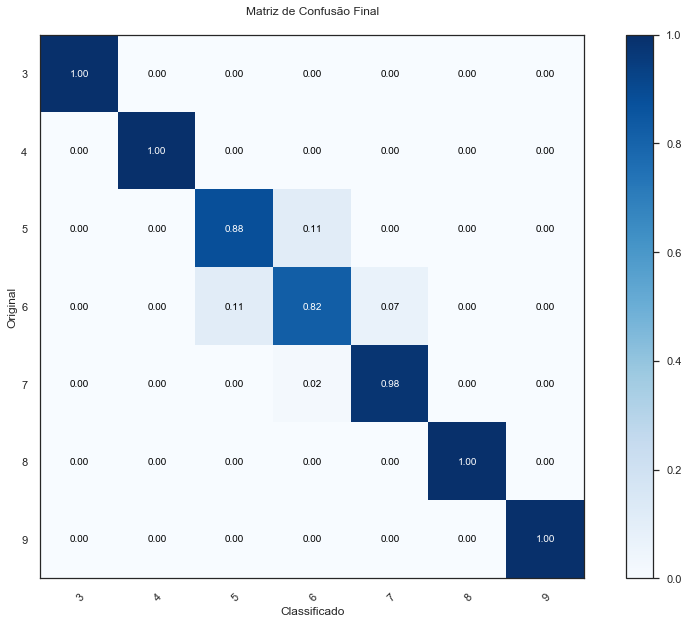

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, 
    test_size = TEST_SIZE, 
    random_state = SEED
)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print('Relatório de classificação:\n')
print(metrics.classification_report(y_test, y_pred))

print('')
plot_confusion_matrix(
    y_test, y_pred, 
    classes=df[CLASS_COLUMN].unique(), 
    normalize=True,
    title="Matriz de Confusão Final"
);

# Conclusões

A partir do estudo conduzido, tomando como base as questões propostas no teste técnico, pode-se concluir que:

**a. Como foi a definição da sua estratégia de modelagem?**

R: Conforme explicado neste notebook, o processo de Análise Exploratória de Dados (EDA, do inglês *Exploratory Data Analysis*) forneceu insights significativos sobre o dataset, suas característias, inconsistências e potenciais. Assim, a modelagem tomou como base o Oversamplig dos dados, a fim de lidar com o forte desbalanceamento de classes existentes. Ainda, a engenharia de atributos adotada envolveu etapas de Codificação One-hot (variável categórica 'Type') e Centralização dos dados, de modo que se buscou construir um pipeline de pré-processamento que viabilizasse a construção de um modelo classificador baseado em Machine Learning eficiente para o problema em questão.

Após o pré-processamento, e análise de diferentes abordagens de classificadores (uma vez que tratamos o problema de análise de classificador como uma saída discreta), avaliamos um conjunto de 5 diferentes algoritmos supervisionados utilizando Validação Cruzada (com 10 folds), que validaram a modelagem desenvolvida.

**b. Como foi definida a função de custo utilizada?**

R: A função de custo escolhida para o modelo final de Floresta Aleatória foi a 'entropia' ([*entropy*](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), que mensura o ganho de informação obtido no processo de estruturação/split das árvores), a qual foi definida analiticamente através do método de pesquisa em grade aleatorizada (RandomizedSearchCV), onde se avaliou a melhor combinação possível de hiperparâmetros - incluindo a função de custo - em um conjunto discreto de opções.

Apesar do viés analítico da escolha, cabe destacar que, conforme [1], a função de custo em si tem pouco efeito prático para esta classe de algoritmo em questão, uma vez que o custo em si é uma medida de impureza da amostragem que está sendo avaliada em cada nó, e todas as métricas são bastante consistentes, em geral; todavia, uma estratégia mais efetiva é escolher cuidadosamente o método de poda das árvores de decisão, o qual tem maior impacto na qualidade do modelo final.

**c. Qual foi o critério utilizado na seleção do modelo final?**

R: A avaliação dos modelos foi feita com base na métrica F1-Score, uma vez que o objetivo era avaliar o desempenho do modelo na perspectiva de seus acertos (Precisão) e seus erros (Recall), tanto de maneira geral (todas as classes) quanto individual (para cada classe - classification_report).
Assim, conforme detalhado no notebook, o modelo final foi escolhido a partir de um benchmarking com modelos concorrentes que foram avaliados sob as mesmas condições utilizando Validação Cruzada. A partir do momento da escolha do melhor modelo, o mesmo foi submetido a um ajuste em grade (Grid Search) de seus hiperparâmetros, que visou definir "o modelo ótimo", o qual foi avaliado novamente com Validação Cruzada 5-folds e Split de Treino/Teste.

**d. Qual foi o critério utilizado para validação do modelo? Por que escolheu utilizar este método?**

R: Foi escolhido a Validação cruzada com 10-folds, uma vez que esta estratégia consegue mensurar com integridade a robustez do modelo, garantindo uma avaliação completa a cerca da generalização do modelo.

**e. Quais evidências você possui de que seu modelo é suficientemente bom?**

R: A partir da combinação da Validação Cruzada com K-folds e a métrica F1-Score, o modelo obteve um desempenho médio final `~89,6%` para <u>TODO</u> o conjunto de dados (10-folds CV) e `~95%` no conjunto de teste, fatores que - em geral - podem indicar um resultado suficientemente "bom", . Todavia, ainda há muitas alternativas que potencialmente poderiam otimizar os resultados, através de estratégias mais avançadas, tais como:

	1. Pré-processamento mais completo (redução da dimensionalidade, clustering, permutação de atributos, etc.);
	2. Otimização mais fina de hiperparâmetros;
	3. Avaliaar modelos mais complexos (Ensembles Hierárquicos, XGboost, e Redes neurais, por exemplo);
	4. Adotar threshold de confiança nas sugestões do modelo (automatizar apenas classificações nas quais o modelo possui "confiança"/probabilidade > C em sua sugestoes - mitigando o risco de erros da IA);

Porém, é importante ressaltar que o critério de aceitação - ou definição de 'bom' - é subjetivo, devendo ser definido cuidadosamente junto ao cliente e especialistas no domínio, a fim de que se entenda por completo os interesses do projeto e os riscos envolvidos nas sugestões do modelo.

# Referências:

    [1] Introduction to Data Mining, 2005. Disponível em https://www-users.cs.umn.edu/~kumar001/dmbook/
    [2] https://scikit-learn.org/stable/user_guide.html
    [3] https://towardsdatascience.com/a-deep-dive-into-imbalanced-data-over-sampling-f1167ed74b5
    [4] https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
    [5] https://machinelearningmastery.com/how-to-tune-algorithm-parameters-with-scikit-learn/
    

# Fim.